In [46]:
import os
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [48]:
artvis_dump_NEW_semicolon_path = r'C:\Studium_Data\IV_Assigment_2\IV-Geographical-Mapping-Visualizator\UE\Assignment_2\data\artvis_dump_NEW-semicolon.csv'
df = pd.read_csv(artvis_dump_NEW_semicolon_path, delimiter=';')

# For testing purposes only use a subset of the data
#df = df.head(100)

# Show first records and DataFrame information
display(df.head())

,a.id,a.firstname,a.lastname,a.gender,a.birthdate,a.deathdate,a.birthplace,a.deathplace,a.nationality,e.id,e.title,e.venue,e.startdate,e.type,e.paintings,e.country,e.city,e.latitude,e.longitude
0,1,William Bernard,Adeney,M,1878-01-01,1966-01-01,London,London,GB,489,"Second Post-Impressionist Exhibition. British,...",Grafton Galleries,1912,group,4,GB,London,51.514248,-0.093145
1,1,William Bernard,Adeney,M,1878-01-01,1966-01-01,London,London,GB,618,Exhibition of the Camden Town Group and Others,Public Art Galleries,1913,group,6,GB,Brighton,50.833333,-0.15
2,1,William Bernard,Adeney,M,1878-01-01,1966-01-01,London,London,GB,720,The Second Exhibition of Works by Members of t...,Goupil Gallery,1915,group,4,GB,London,51.514248,-0.093145
3,1,William Bernard,Adeney,M,1878-01-01,1966-01-01,London,London,GB,729,Third Exhibition of Works by Members of the Lo...,Goupil Gallery,1915,group,5,GB,London,51.514248,-0.093145
4,1,William Bernard,Adeney,M,1878-01-01,1966-01-01,London,London,GB,650,The First Exhibition of Works by Members of Th...,Goupil Gallery,1914,group,5,GB,London,51.514248,-0.093145


### Preprocessing Data

In [50]:
# For clarity, rename columns to simpler labels:
df.rename(columns={
    'a.id': 'artist_id',
    'a.firstname': 'firstname',
    'a.lastname': 'lastname',
    'a.gender': 'gender',
    'a.birthdate': 'birthdate',
    'a.deathdate': 'deathdate',
    'a.birthplace': 'birthplace',
    'a.deathplace': 'deathplace',
    'a.nationality': 'nationality',
    'e.id': 'exhibition_id',
    'e.title': 'exhibition_title',
    'e.venue': 'exhibition_venue',
    'e.startdate': 'exhibition_date',
    'e.type': 'exhibition_type',
    'e.paintings': 'num_paintings',
    'e.country': 'exhibition_country',
    'e.city': 'exhibition_city',
    'e.latitude': 'exhibition_lat',
    'e.longitude': 'exhibition_lon'
}, inplace=True)

In [51]:
artist_counts = df.groupby('artist_id')['exhibition_id'].nunique().reset_index()
# Sort descending by number of exhibitions
artist_counts.sort_values('exhibition_id', ascending=False, inplace=True)

# Choose how many you want to keep
TOP_N = 50
top_artists = artist_counts.head(TOP_N)['artist_id'].unique()

df = df[df['artist_id'].isin(top_artists)]

In [52]:
# Converting birthdate, deathdate to datetime
df['a.birthdate'] = pd.to_datetime(df['a.birthdate'], errors='coerce')
df['a.deathdate'] = pd.to_datetime(df['a.deathdate'], errors='coerce')
df['e.startdate'] = pd.to_datetime(df['e.startdate'], errors='coerce')

KeyError: 'a.birthdate'

### Building the mapping of artists to their exhibitions

In [53]:
exhibition_groups = df.groupby('exhibition_id')['artist_id'].apply(list).reset_index()
exhibition_groups.head()

,exhibition_id,artist_id
0,3,"[5, 5, 65, 65, 164, 164, 225, 225, 364, 364, 4..."
1,5,[400]
2,7,"[276, 276]"
3,8,"[37, 208, 248, 416]"
4,12,[301]


In [54]:
# For quick access to artist information, we can create a separate DataFrame with unique artist information
artist_info = df.groupby('artist_id').agg({
    'firstname': 'first',
    'lastname': 'first',
    'gender': 'first',
    'birthdate': 'first',
    'deathdate': 'first',
    'birthplace': 'first',
    'deathplace': 'first',
    'nationality': 'first'
}).reset_index()

In [55]:
# For easier attribute assignment to nodes, we can convert the artist_info DataFrame to a dictionary
artist_attr_dict = artist_info.set_index('artist_id').to_dict(orient='index')

### Building the Collaboration Network

In [57]:
G = nx.Graph()

# Add top artists as nodes, with their attributes
for artist_id, attr_dict in artist_attr_dict.items():
    G.add_node(artist_id, **attr_dict)

# Add edges based on shared exhibitions, counting the weight
for _, row in exhibition_groups.iterrows():
    artist_list = row['artist_id']
    for combo in combinations(artist_list, 2):
        a1, a2 = combo
        if G.has_edge(a1, a2):
            G[a1][a2]['weight'] += 1
        else:
            G.add_edge(a1, a2, weight=1)

### Visualizing the Network

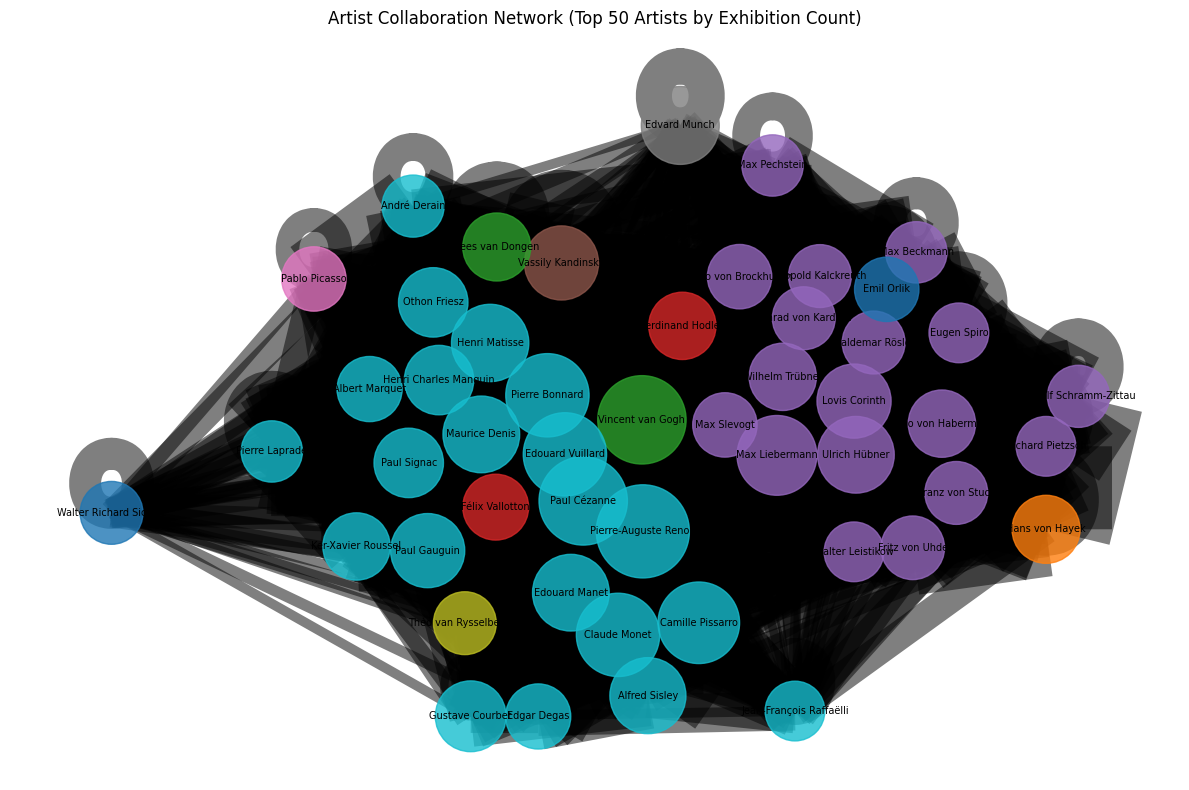

In [58]:
plt.figure(figsize=(12, 8))

# For the layout, a smaller graph is more manageable.
pos = nx.spring_layout(G, k=0.9, seed=42)

# Build color map for nationalities
nationalities = list({G.nodes[n]['nationality'] for n in G.nodes()})
color_map = {}
for i, nat in enumerate(nationalities):
    color_map[nat] = f'C{i % 10}'  # cycle through default matplotlib colors

node_colors = [color_map[G.nodes[n]['nationality']] for n in G.nodes()]

# Size nodes by # of exhibitions
# (We need to re-derive from the *filtered* df)
artist_exh_counts = df.groupby('artist_id')['exhibition_id'].nunique().to_dict()
node_sizes = [artist_exh_counts.get(n, 0)*50 for n in G.nodes()]

# Edge widths reflect edge weights
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos,
                       node_color=node_colors,
                       node_size=node_sizes,
                       alpha=0.8)
nx.draw_networkx_edges(G, pos,
                       width=edge_widths,
                       alpha=0.5)

labels = {
    n: f"{G.nodes[n]['firstname']} {G.nodes[n]['lastname']}"
    for n in G.nodes()
}
nx.draw_networkx_labels(G, pos, labels, font_size=7)

plt.title(f"Artist Collaboration Network (Top {TOP_N} Artists by Exhibition Count)")
plt.axis("off")
plt.tight_layout()
plt.show()

### Saving data as .json for d3

In [59]:
import json
from networkx.readwrite import json_graph

# Convert the NetworkX graph 'G' into a JSON-serializable dictionary
graph_data = json_graph.node_link_data(G)

# Write that dictionary out as JSON, using default=str to handle timestamps
with open('artist_collaboration_network.json', 'w', encoding='utf-8') as outfile:
    json.dump(graph_data, outfile, indent=2, ensure_ascii=False, default=str)

c:\Studium_Data\IV_Assigment_2\IV-Geographical-Mapping-Visualizator\UE\Assignment_2\.venv\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(
